# Taller 2

Juan Sebastian Alvarez Eraso

Código: 201822427

## Inicio

La alcaldía de una ciudad está interesada en implementar un nuevo servicio de patinetas para incentivar la movilidad sostenible y como parte de este proceso se encuentra evaluando la viabilidad económica e impacto de dicho servicio.

Dado lo anterior, le ha encargado a la consultora Andes CDA el desarrollo de un modelo predictivo de la demanda de patinetas por día con base en datos de una ciudad vecina. Su objetivo como consultor de esta empresa es la creación del mejor modelo posible de regresión lineal que le permita predecir el número de usuarios promedio por día del nuevo servicio, al mismo tiempo de poder entender la importancia y relación de las variables consideradas.

In [1]:
# Setup
RUTA_DEL_DATASET = 'https://raw.githubusercontent.com/juanalvarez123/MINE-4101-taller-2/main/Dataset/Data_Taller_2.csv'

import pandas as pd
import warnings

# Configuración de pandas para extender el número de filas y columnas en la visualización
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# Deshabilitar warnings
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

## Limpieza y preparación de los datos

In [2]:
# Creo el dataset a partir de la data del archivo CSV
df = pd.read_csv(RUTA_DEL_DATASET, sep=';')
df.head()

,instant,Date,Season,Holiday,Weather,Temp,Feel_Temp,Hum,Wind,Casual,Registered,cnt
0,1,1/01/2020,Springer,No,Mist + Cloudy,"8,175849","9,090375","0,805833","10,749882",331,654,985
1,2,2/01/2020,Springer,No,Mist + Cloudy,"9,083466","8,625733","0,696087","-16,652113",131,670,801
2,3,3/01/2020,Springer,No,Few clouds,"1,229108","0,902035","0,437273","16,636703",120,1229,1349
3,4,4/01/2020,Springer,No,Few clouds,"1,4","1,969734","0,590435","10,739832",108,1454,1562
4,5,5/01/2020,Springer,No,Partly cloudy,"2,666979","2,77569","0,436957","12,5223",82,1518,1600


In [3]:
# Verifico la cantidad de registros y de columnas
df.shape

(731, 12)

In [4]:
# Verifico la cantidad de nulos
df.isnull().sum()

instant       0
Date          0
Season        0
Holiday       0
Weather       0
Temp          4
Feel_Temp     0
Hum           0
Wind          0
Casual        0
Registered    0
cnt           0
dtype: int64

Hay 4 nulos para la columna "Temp".

In [5]:
# Verifico los typos de datos de los features
df.dtypes

instant        int64
Date          object
Season        object
Holiday       object
Weather       object
Temp          object
Feel_Temp     object
Hum           object
Wind          object
Casual         int64
Registered     int64
cnt            int64
dtype: object

Para revisar:
* La columna "Date" contiene una fecha y su tipo de dato es "object".
* Las columnas "Temp", "Feel_Temp", "Hum" y "Wind" contienen datos numéricos pero su tipo de dato es un "object".

In [6]:
# Puede que al ser tipo de dato "object" existan valores vacíos y no aparecieron
# anteriormente como nulos, procedo a verificar
df[(df['Date'] == '') |
   (df['Season'] == '') |
   (df['Holiday'] == '') |
   (df['Weather'] == '') |
   (df['Temp'] == '') |
   (df['Feel_Temp'] == '') |
   (df['Hum'] == '') |
   (df['Wind'] == '')]

,instant,Date,Season,Holiday,Weather,Temp,Feel_Temp,Hum,Wind,Casual,Registered,cnt


No hay columnas que contengan datos vacíos, se puede continuar.

In [7]:
# Verifico si la columa "instant" se refiere al mismo índice del dataset.
# Para eso creo una columna temporal que me registre el índice del dataset.
df['tmp_index'] = range(1, len(df) + 1)

# Y luego verifico la correlación de estas dos columnas
df[['instant', 'tmp_index']].corr()

,instant,tmp_index
instant,1.0,1.0
tmp_index,1.0,1.0


Se puede ver que la correlación de estas 2 columnas es de 1, lo que quiere decir que efectivamente la columna "instant" corresponde al índice del dataset.

In [8]:
# Verifico los valores únicos de la columna "Holiday"
df['Holiday'].unique()

array(['No', 'Yes'], dtype=object)

In [9]:
# Verifico los valores únicos de la columna "Weather"
df['Weather'].unique()

array(['Mist + Cloudy', 'Few clouds', ' Partly    cloudy', 'Clear',
       'Mist', 'Mist + Broken clouds', ' Partly cloudy',
       'Mist + Few clouds', 'Rain + Thunderstorm',
       'Light Rain + Scattered clouds', 'Snow'], dtype=object)

Se puede ver que hay 2 valores parecidos: ' Partly&nbsp;&nbsp;&nbsp;&nbsp;cloudy' y ' Partly cloudy', la diferencia solo está en sus espacios internos y externos. Es buena idea unificarlos siguiendo las recomendaciones del meteorólogo.

Por lo visto anteriormente he tomado las siguientes determinaciones:
1. Cambiar el tipo de dato de la columna "Date" para que soporte una fecha. Me permitirá trabajar mejor y obtener más información que con un "object". También verificar si hay duplicados.
2. A partir de la fecha corregida obtengo el año, mes y día de la semana por cada registro. El feature "Date" ya no es necesario en mi modelo.
3. Cambiar el tipo de dato de las columnas "Temp", "Feel_Temp", "Hum" y "Wind". Estas contienen valores numéricos.
4. Completar los datos nulos de la columna "Temp" con la media de la columna.
5. La columna "instant" se puede eliminar, se comprobó que efectivamente correspondía al mismo índice. También se puede eliminar la columna "tmp_index" que se creó de forma temporal.
6. Cambiar los valores y el tipo de dato de la columna "Holiday". Es mejor trabajar con un dato cuantitativo antes que con un categórico.
7. Unifico los valores de "Weather" según la recomendación del meteorólogo.

In [10]:
# 1. Cambiar el tipo de dato de la columna "Date" para que soporte una fecha.

# Se utiliza el parámetro errors='coerce' para evitar que la conversión falle
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y', errors='coerce')

# Se imprime el registro que tuvo la fecha mal
df[df['Date'].isnull()]

,instant,Date,Season,Holiday,Weather,Temp,Feel_Temp,Hum,Wind,Casual,Registered,cnt,tmp_index
424,425,NaT,Springer,No,Mist,"8,184356","8,37809","0,804783","12,000839",65,1769,1834,425


Al revisarlo en el dataset se observa que contenía la fecha 29/02/2021 y esa fecha no existe; febrero en el 2021 solo tuvo 28 días.

Para no eliminar el registro he decidido colocarle la fecha correcta del siguiente día, es decir, el 01/03/2021.

In [11]:
df.loc[df['Date'].isnull(), 'Date'] = pd.to_datetime('01/03/2021', format='%d/%m/%Y')

# Imprimo nuevamente si hay registros con fechas incorrectas
df[df['Date'].isnull()]

,instant,Date,Season,Holiday,Weather,Temp,Feel_Temp,Hum,Wind,Casual,Registered,cnt,tmp_index


Ya no hay registros con fechas incorrectas.

In [12]:
# Verifico el tipo de datos de las columnas
df.dtypes

instant                int64
Date          datetime64[ns]
Season                object
Holiday               object
Weather               object
Temp                  object
Feel_Temp             object
Hum                   object
Wind                  object
Casual                 int64
Registered             int64
cnt                    int64
tmp_index              int64
dtype: object

Listo, la columna "Date" ahora es del tipo de dato `datetime`.

In [13]:
# Busco los duplicados por fecha
duplicates_by_date = df.loc[df['Date'].duplicated(keep = False)]
duplicates_by_date

,instant,Date,Season,Holiday,Weather,Temp,Feel_Temp,Hum,Wind,Casual,Registered,cnt,tmp_index
424,425,2021-03-01,Springer,No,Mist,"8,184356","8,37809","0,804783","12,000839",65,1769,1834,425
425,426,2021-03-01,Springer,No,Clear,"14,834151","14,342437","0,615417","15,208129",325,4665,4990,426


Aunque hay 2 registos que tienen la misma fecha no son registros duplicados por que corresponden a diferente clima y cantidad de rentas de patinetas.

In [14]:
# 2. A partir de la fecha corregida obtengo el año, mes y día de la semana
import calendar

df['year'] = df['Date'].apply(lambda x: x.year)
df['month'] = df['Date'].apply(lambda x: x.strftime("%B"))
df['weekday'] = df['Date'].apply(lambda x: calendar.day_name[x.weekday()])

# Luego, 'Date' como feature ya no lo necesito en mi modelo, voy a eliminar la columna
df.drop('Date', axis=1, inplace=True)

In [15]:
# 3. Cambiar el tipo de dato de las columnas "Temp", "Feel_Temp", "Hum" y "Wind"
import numpy as np

def replace_comma(value):
  return str(value).replace(",", ".")

df['Temp'] = df['Temp'].apply(replace_comma)
df['Feel_Temp'] = df['Feel_Temp'].apply(replace_comma)
df['Hum'] = df['Hum'].apply(replace_comma)
df['Wind'] = df['Wind'].apply(replace_comma)

df = df.astype({'Temp': np.float64,
                'Feel_Temp': np.float64,
                'Hum': np.float64,
                'Wind': np.float64})

# Imprimo nuevamente los tipos de datos
df.dtypes

instant         int64
Season         object
Holiday        object
Weather        object
Temp          float64
Feel_Temp     float64
Hum           float64
Wind          float64
Casual          int64
Registered      int64
cnt             int64
tmp_index       int64
year            int64
month          object
weekday        object
dtype: object

Ya se pueden observar los tipos de dato de "Temp", "Feel_Temp", "Hum" y "Wind" como float64.

In [16]:
# 4. Completar los datos nulos de la columna "Temp" con la media de la columna
df.fillna(value={'Temp': np.mean(df['Temp'], axis=0)}, inplace=True)

# Verifico nuevamente que no haya nulos
df.isnull().sum()

instant       0
Season        0
Holiday       0
Weather       0
Temp          0
Feel_Temp     0
Hum           0
Wind          0
Casual        0
Registered    0
cnt           0
tmp_index     0
year          0
month         0
weekday       0
dtype: int64

Ya no hay nulos en el dataset.

In [17]:
# 5. Eliminar las columnas "instant" y "tmp_index"
df.drop('instant', axis=1, inplace=True)
df.drop('tmp_index', axis=1, inplace=True)

# Verifico la cantidad de columnas nuevamente, deberían ser 13 ahora
df.shape

(731, 13)

In [18]:
# 6. Cambiar los valores y el tipo de dato de la columna "Holiday"
df['Holiday'] = df['Holiday'].apply(lambda x: 1 if x == 'Yes' else 0)

df = df.astype({'Holiday': np.bool_})

# Imprimo nuevamente los tipos de datos
df.dtypes

Season         object
Holiday          bool
Weather        object
Temp          float64
Feel_Temp     float64
Hum           float64
Wind          float64
Casual          int64
Registered      int64
cnt             int64
year            int64
month          object
weekday        object
dtype: object

Ya se puede observar el tipo de dato de "Holiday" actualizado a booleano.

In [19]:
# 7. Unifico los valores de "Weather" según la recomendación del meteorólogo
def unify_weather(value):
  if 'Mist' in value:
    return 'Mist'
  elif 'Rain' in value:
    return 'Rain'
  else:
    return 'Other'

df['Weather'] = df['Weather'].apply(unify_weather)

# Verifico nuevamente los valores únicos de "Weather", ya se deben ver mejor
df['Weather'].unique()

array(['Mist', 'Other', 'Rain'], dtype=object)

In [20]:
# Imprimo de nuevo el dataset, ya se puede ver con las mejoras aplicadas
df.head()

,Season,Holiday,Weather,Temp,Feel_Temp,Hum,Wind,Casual,Registered,cnt,year,month,weekday
0,Springer,False,Mist,8.175849,9.090375,0.805833,10.749882,331,654,985,2020,January,Wednesday
1,Springer,False,Mist,9.083466,8.625733,0.696087,-16.652113,131,670,801,2020,January,Thursday
2,Springer,False,Other,1.229108,0.902035,0.437273,16.636703,120,1229,1349,2020,January,Friday
3,Springer,False,Other,1.400000,1.969734,0.590435,10.739832,108,1454,1562,2020,January,Saturday
4,Springer,False,Other,2.666979,2.775690,0.436957,12.522300,82,1518,1600,2020,January,Sunday


In [21]:
# Imprimo la cantidad de registros y la cantidad de features
df.shape

(731, 13)

## Análisis de datos

In [22]:
# Verifico cuál es la distribución de la variable dependiente (target)
df['cnt'].describe(percentiles = [.25, .5, .75, .99, 1])

count     731.000000
mean     4504.348837
std      1937.211452
min        22.000000
25%      3152.000000
50%      4548.000000
75%      5956.000000
99%      8163.700000
100%     8714.000000
max      8714.000000
Name: cnt, dtype: float64

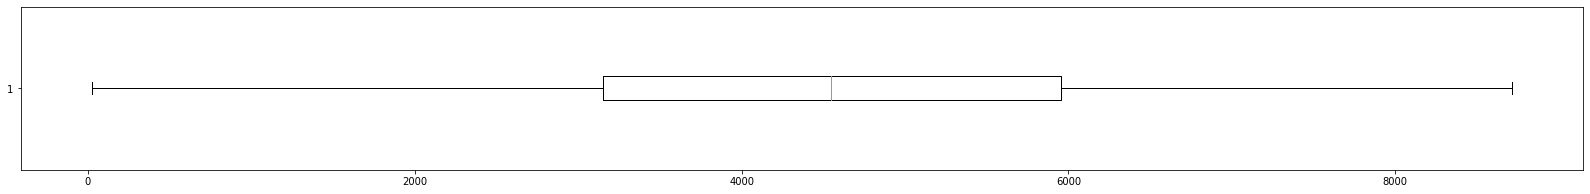

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize = (28, 3))
plt.boxplot(df['cnt'], vert = False)
plt.show()

Los datos de las cantidades de rentas de patinetas están balanceados.

In [24]:
# Busco la correlación de las variables
df.corr()

,Holiday,Temp,Feel_Temp,Hum,Wind,Casual,Registered,cnt,year
Holiday,1.000000,-0.028417,-0.032507,-0.015569,0.009009,0.054274,-0.108745,-0.068348,0.007954
Temp,-0.028417,1.000000,0.987659,-0.000575,-0.143290,0.543683,0.536810,0.625056,0.048597
Feel_Temp,-0.032507,0.987659,1.000000,-0.021285,-0.171659,0.543864,0.544192,0.631066,0.046106
Hum,-0.015569,-0.000575,-0.021285,1.000000,-0.026731,-0.008490,-0.055816,-0.047965,-0.021094
Wind,0.009009,-0.143290,-0.171659,-0.026731,1.000000,-0.154652,-0.197764,-0.214097,-0.005097
Casual,0.054274,0.543683,0.543864,-0.008490,-0.154652,1.000000,0.395282,0.672804,0.248546
Registered,-0.108745,0.536810,0.544192,-0.055816,-0.197764,0.395282,1.000000,0.945517,0.594248
cnt,-0.068348,0.625056,0.631066,-0.047965,-0.214097,0.672804,0.945517,1.000000,0.566710
year,0.007954,0.048597,0.046106,-0.021094,-0.005097,0.248546,0.594248,0.566710,1.000000


Las correlaciones más altas se ven entre la cantidad de usuarios registrados que rentan patinetas (Registered) y la cantidad total de rentas de patinetas (cnt).

También se ven correlaciones altas de la temperatura (Temp) y la cantidad total de rentas de patinetas (cnt).

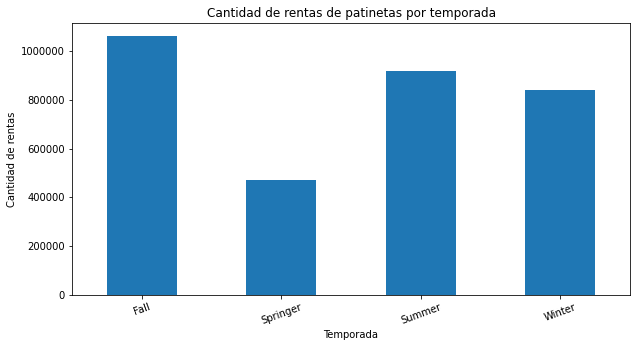

In [25]:
# ¿Cuál es la temporada del año donde hay más rentas patinetas?
import matplotlib.pyplot as plt 

plt.figure(figsize = (10,5))
seasons_df = df.groupby(['Season']).agg({'cnt': 'sum'})
ax = seasons_df['cnt'].plot(kind='bar', title='Cantidad de rentas de patinetas por temporada')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 20)
plt.xlabel('Temporada')
plt.ylabel('Cantidad de rentas')

# Se formatean los valores del eje "y"
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])

plt.show()

Otoño es donde más se rentan patientas con más de 1.000.000 de rentas al contrario de la primavera que es donde menos se observan rentas con aproximadamente 500.000 rentas.

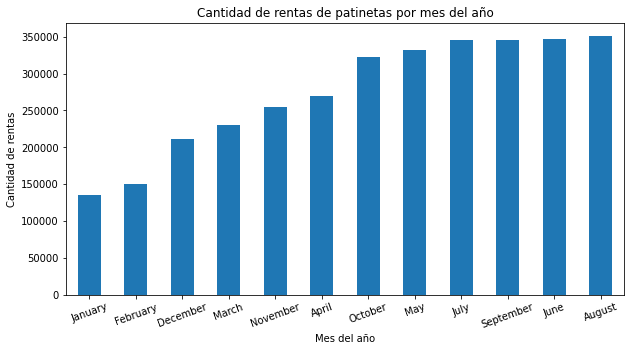

In [26]:
# ¿Cuál es el mes del año donde hay más rentas patinetas?
plt.figure(figsize = (10,5))
weekdays_df = df.groupby(['month']).agg({'cnt': 'sum'}).sort_values('cnt', ascending=True)
ax = weekdays_df['cnt'].plot(kind='bar', title='Cantidad de rentas de patinetas por mes del año')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 20)
plt.xlabel('Mes del año')
plt.ylabel('Cantidad de rentas')

plt.show()

Se puede observar que hay 3 meses del año donde la renta de patinetas es menor, corresponden a diciembre, enero y febrero.

La época de fin de año y de inicio de año no es un buen momento para invertir en patinetas para rentar y a los usuarios no les interesa rentar tampoco, seguro están con otros asuntos pendientes.

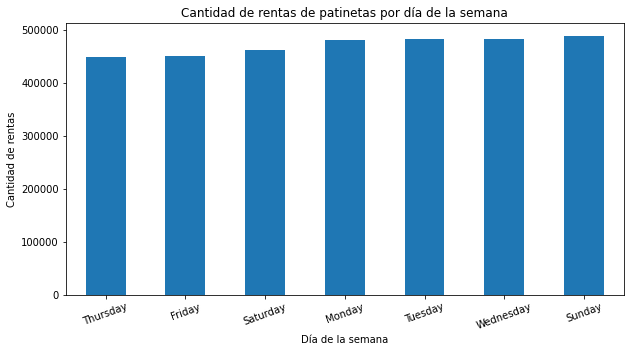

In [27]:
# ¿Cuál es el día de la semana donde más rentas patinetas?
plt.figure(figsize = (10,5))
weekdays_df = df.groupby(['weekday']).agg({'cnt': 'sum'}).sort_values('cnt', ascending=True)
ax = weekdays_df['cnt'].plot(kind='bar', title='Cantidad de rentas de patinetas por día de la semana')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 20)
plt.xlabel('Día de la semana')
plt.ylabel('Cantidad de rentas')

plt.show()

Los rentas por día de la semana varían entre los 450.000 y los 500.000. La diferencia no es mucha.

El día con menos rentas es el jueves y el día con más rentas es el domingo.

Esto quiere quiere decir que los usuarios no tienen mucha preferencia por el día de la semana que rentan la patineta.

## Modelos de Machine Learning

Me dispongo a preparar los datos, tener listos los datasets de la variable dependiente y las variables independientes:

In [28]:
# Preparo todos los datos para tenerlos como cuantitativos aplicando un encoding
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Con el parámetro "drop ='first'" se elimina una columna de cada feature y así se evita la multicolinealidad
columns = ['Season', 'Holiday', 'Weather', 'month', 'weekday']
ct = ColumnTransformer(transformers = [('OneHotEncoder',
                                        OneHotEncoder(sparse = False, drop ='first'), columns)],
                       remainder = 'passthrough')
df2 = ct.fit_transform(df)
df2 = pd.DataFrame(data=df2, columns=ct.get_feature_names_out())

df2.head()

,OneHotEncoder__Season_Springer,OneHotEncoder__Season_Summer,OneHotEncoder__Season_Winter,OneHotEncoder__Holiday_True,OneHotEncoder__Weather_Other,OneHotEncoder__Weather_Rain,OneHotEncoder__month_August,OneHotEncoder__month_December,OneHotEncoder__month_February,OneHotEncoder__month_January,OneHotEncoder__month_July,OneHotEncoder__month_June,OneHotEncoder__month_March,OneHotEncoder__month_May,OneHotEncoder__month_November,OneHotEncoder__month_October,OneHotEncoder__month_September,OneHotEncoder__weekday_Monday,OneHotEncoder__weekday_Saturday,OneHotEncoder__weekday_Sunday,OneHotEncoder__weekday_Thursday,OneHotEncoder__weekday_Tuesday,OneHotEncoder__weekday_Wednesday,remainder__Temp,remainder__Feel_Temp,remainder__Hum,remainder__Wind,remainder__Casual,remainder__Registered,remainder__cnt,remainder__year
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,8.175849,9.090375,0.805833,10.749882,331.0,654.0,985.0,2020.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,9.083466,8.625733,0.696087,-16.652113,131.0,670.0,801.0,2020.0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.229108,0.902035,0.437273,16.636703,120.0,1229.0,1349.0,2020.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.400000,1.969734,0.590435,10.739832,108.0,1454.0,1562.0,2020.0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.666979,2.775690,0.436957,12.522300,82.0,1518.0,1600.0,2020.0


In [29]:
# Imprimo la cantidad de registros y columnas del nuevo dataframe
df2.shape

(731, 31)

Pasamos de tener 13 columnas a trabajar con 31

In [30]:
# La variable dependiente sera 'cnt', las demas serán independientes
x = df2.drop('remainder__cnt', axis=1)
y = df2['remainder__cnt']

In [31]:
# Reviso la distribución de la variable dependiente (target)
df2['remainder__cnt'].describe(percentiles = [.25, .5, .75, .99])

count     731.000000
mean     4504.348837
std      1937.211452
min        22.000000
25%      3152.000000
50%      4548.000000
75%      5956.000000
99%      8163.700000
max      8714.000000
Name: remainder__cnt, dtype: float64

In [32]:
# Se divide el dataset en entrenamiento y prueba, donde entrenamiento tendrá el 80% de los datos
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=1)

print(f'Train: {x_train.shape}')
print(f'Test: {x_test.shape}')

# Se estandariza el dataset usando 'StandarScaler'
name_columns = x_train.columns

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(x_train.values) # Solo para datos de entrenamiento se utiliza "fit_transform"
x_test = sc.transform(x_test.values)

# Los datos se transforman a dataframes para mayor comodidad
x_train = pd.DataFrame(data=x_train, columns=name_columns)
x_test = pd.DataFrame(data=x_test, columns=name_columns)

Train: (584, 30)
Test: (147, 30)


### Regresión lineal simple

In [33]:
# Se realiza el entrenamiento del modelo
from sklearn.linear_model import LinearRegression

simple_linear_regression = LinearRegression()
simple_linear_regression.fit(x_train, y_train)

# Se predicen los datos
y_pred_train = simple_linear_regression.predict(x_train)
y_pred_test = simple_linear_regression.predict(x_test)

# Se imprimen los valores de los coeficientes. Los que tengan una magnitud más
# grande son los que influyen más en la desición de la predicción
print(simple_linear_regression.feature_names_in_)
print(simple_linear_regression.coef_)

['OneHotEncoder__Season_Springer' 'OneHotEncoder__Season_Summer'
 'OneHotEncoder__Season_Winter' 'OneHotEncoder__Holiday_True'
 'OneHotEncoder__Weather_Other' 'OneHotEncoder__Weather_Rain'
 'OneHotEncoder__month_August' 'OneHotEncoder__month_December'
 'OneHotEncoder__month_February' 'OneHotEncoder__month_January'
 'OneHotEncoder__month_July' 'OneHotEncoder__month_June'
 'OneHotEncoder__month_March' 'OneHotEncoder__month_May'
 'OneHotEncoder__month_November' 'OneHotEncoder__month_October'
 'OneHotEncoder__month_September' 'OneHotEncoder__weekday_Monday'
 'OneHotEncoder__weekday_Saturday' 'OneHotEncoder__weekday_Sunday'
 'OneHotEncoder__weekday_Thursday' 'OneHotEncoder__weekday_Tuesday'
 'OneHotEncoder__weekday_Wednesday' 'remainder__Temp'
 'remainder__Feel_Temp' 'remainder__Hum' 'remainder__Wind'
 'remainder__Casual' 'remainder__Registered' 'remainder__year']
[-1.17182867e-12 -3.41060513e-13  3.27462726e-13 -1.75885007e-13
  4.14802378e-13 -3.39160745e-13  7.99016046e-13 -3.82534444e-1

Los valores más grandes son los que están ubicados en las posiciones 13, 26 y 27 que corresponden a los features 'Mes: Marzo', 'Hum' y 'Wind' respectivamente.

Estos son los que influyen más en la predicción.

In [34]:
# Encuentro la raíz del error cuadrático medio (RMSE) para datos de train y de test
from sklearn.metrics import mean_squared_error

lr_train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
lr_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f'LinearRegression train RMSE: {lr_train_rmse}')
print(f'LinearRegression test RMSE: {lr_test_rmse}')

LinearRegression train RMSE: 1.9964378567754444e-12
LinearRegression test RMSE: 2.128993220292346e-12


### Gradiente descendiente con función de regularización

In [35]:
# Se realiza el entrenamiento del modelo con función de regularización L1
from sklearn.linear_model import SGDRegressor

sgd_l1_regressor = SGDRegressor(penalty='l1')
sgd_l1_regressor.fit(x_train, y_train)

# Se predicen los datos
y_pred_train = sgd_l1_regressor.predict(x_train)
y_pred_test = sgd_l1_regressor.predict(x_test)

# Encuentro la raíz del error cuadrático medio (RMSE) para datos de train y de test
sgd_l1_train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
sgd_l1_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f'SGDRegressor L1 train RMSE: {sgd_l1_train_rmse}')
print(f'SGDRegressor L1 test RMSE: {sgd_l1_test_rmse}')

SGDRegressor L1 train RMSE: 0.3030766612035351
SGDRegressor L1 test RMSE: 0.3245606663459617


### Transformación polinomial

In [36]:
# Polinomio con 2 grados
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
x_poly = poly_features.fit_transform(x)

In [37]:
# Obtener variable dependiente y variables independientes
x_train, x_test, y_train, y_test = train_test_split(x_poly, y, test_size=0.20, random_state=1)

print(f'Train: {x_train.shape}')
print(f'Test: {x_test.shape}')

# Se estandariza el dataset usando 'StandarScaler'
sc = StandardScaler()
x_train = sc.fit_transform(x_train) # Solo para datos de entrenamiento se utiliza "fit_transform"
x_test = sc.transform(x_test)

Train: (584, 495)
Test: (147, 495)


El número de features aumentó a 495.

In [38]:
# Se realiza el entrenamiento del modelo sin función de regularización
from sklearn.linear_model import SGDRegressor

sgd_poly2_regressor = SGDRegressor(penalty=None)
sgd_poly2_regressor.fit(x_train, y_train)

# Se predicen los datos
y_pred_train = sgd_poly2_regressor.predict(x_train)
y_pred_test = sgd_poly2_regressor.predict(x_test)

# Encuentro la raíz del error cuadrático medio (RMSE) para datos de train y de test
sgd_poly2_train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
sgd_poly2_test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f'SGDRegressor Poly2 train RMSE: {sgd_poly2_train_rmse}')
print(f'SGDRegressor Poly2 test RMSE: {sgd_poly2_test_rmse}')

SGDRegressor Poly2 train RMSE: 93097534.30761978
SGDRegressor Poly2 test RMSE: 201861638.5798711


## Conclusiones

1. El mejor modelo es el realizado con regresión lineal, la razón es por que el RMSE encontrado es el menor de los 3 modelos y es muy cercano a 0.
2. La regresión con gradiente descendente y sin función de regularizacón arrojó un RMSE pequeño y cercano a 0, sin embargo, al compararlo con el RMSE de la regresión lineal este le sigue ganando.
3. Al aplicar los modelos con transformación polinomial y gradiente descendente sin función de regularización el RMSE no mejora. Esto sucede por que el modelo no tiene overfitting.


## Respuestas a las preguntas

¿Cuáles son las 3 variables más importantes para la predicción de la cantidad de usuarios?

Rta/ Los features que más influyen en la predicción son 'Mes: Marzo', 'Hum' y 'Wind'. Sus magnitudes son las más grandes.

Describa cual es el escenario ideal para el incremento de usuarios.

Rta/ El escenario ideal para contar con más usuarios es evitar hacer campañas al final del año e inicios del año ya que no hay muchos usuarios que arrienden patinetas. También hacer enfasis en los meses del año donde las condiciones de humedad y viento son favorables, por ejemplo: mitad de año en verano. Los usuarios no tienen una preferencia marcada por el día de la semana que usan la patineta, así que está bien hacer promociones todos los días.

¿Qué pasos adicionales deberían tener en cuenta para una próxima iteración/mejora del modelo?

Rta/ Se puede considerar:
1. Tener más datos de entrenamiento y de test.
2. Contar con más features, por ejemplo: Género del usuario, medio de pago utilizado, duración promedio de los trayectos, etc.
3. Contar en lo posible con la menor cantidad de nulos y datos vacíos.